In [1]:
import numpy as np
import pandas as pd 
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import SGD, Adam
import bz2
import csv
from sklearn.metrics import roc_auc_score

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# Load the training data 
training_data = bz2.BZ2File("./train.ft.txt.bz2")
training_data = training_data.readlines()
training_data = [x.decode('utf-8') for x in training_data]
print(len(training_data))

# Load the test data 
test_data = bz2.BZ2File("./test.ft.txt.bz2")
test_data = test_data.readlines()
test_data = [x.decode('utf-8') for x in test_data]
print(len(test_data))

3600000
400000


In [3]:
# Split the data into labels and texts
train_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in training_data]
train_texts = [re.sub(r'__label__\d ', '', line) for line in training_data]

test_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in test_data]
test_texts = [re.sub(r'__label__\d ', '', line) for line in test_data]

# Convert labels to binary (0 and 1)
train_labels = [0 if label == 1 else 1 for label in train_labels]
test_labels = [0 if label == 1 else 1 for label in test_labels]

**Text Preprocessing**

In [4]:
def clean_text(text):
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

In [5]:
train_texts=pd.DataFrame(train_texts)[0].apply(clean_text)
test_texts=pd.DataFrame(test_texts)[0].apply(clean_text)

In [6]:
pd.DataFrame(test_labels).value_counts()

0    200000
1    200000
dtype: int64

In [7]:
len(train_texts)

3600000

In [8]:
len(test_texts)

400000

In [9]:
# Tokenization and padding
max_words = 1000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [10]:
X_train = np.array(X_train)
print(X_train.shape)
X_test = np.array(X_test)
print(X_test.shape)
y_train = np.array(train_labels)
print(y_train.shape)
y_test = np.array(test_labels)
print(y_test.shape)

(3600000, 100)
(400000, 100)
(3600000,)
(400000,)


In [11]:
## Create the model

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(rate=0.2))  
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          128000    
                                                                 
 lstm (LSTM)                 (None, 100, 128)          131584    
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 391,297
Trainable params: 391,297
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, batch_size=2048, verbose=1, validation_split=.1)

Epoch 1/2
1583/1583 [==============================] - 6755s 4s/step - loss: 0.2540 - accuracy: 0.8933 - val_loss: 0.2274 - val_accuracy: 0.9078
Epoch 2/2
1583/1583 [==============================] - 6499s 4s/step - loss: 0.2046 - accuracy: 0.9174 - val_loss: 0.1912 - val_accuracy: 0.9235


In [15]:
loss,accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

12500/12500 [==============================] - 843s 67ms/step - loss: 0.1976 - accuracy: 0.9206
Loss: 0.19760292768478394
Accuracy: 0.9205600023269653


In [16]:
prediction=model.predict(X_test)
y_pred=np.where(prediction>=.5,1,0)
df=pd.DataFrame()
df['actual'],df['pred']=y_test,y_pred

12500/12500 [==============================] - 714s 57ms/step


In [17]:
df

,actual,pred
0,1,1
1,1,1
2,0,0
3,1,1
4,1,1
...,...,...
399995,0,0
399996,0,0
399997,0,0
399998,1,1


array([[186644,  13356],
       [ 18420, 181580]], dtype=int64)

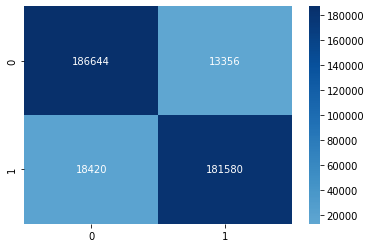

In [18]:
# Evaluate with a confusion matrix and classification report

import seaborn as sns
CM = confusion_matrix(y_test, y_pred)
sns.heatmap(CM,annot=True,center = True,fmt='g',cmap='Blues')
CM

<AxesSubplot:>

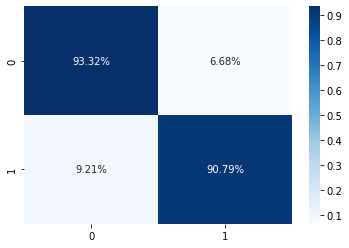

In [30]:
import numpy as np
sns.heatmap(CM/np.sum(CM,axis=1), annot=True, 
            fmt='.2%', cmap='Blues')


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92    200000
           1       0.93      0.91      0.92    200000

    accuracy                           0.92    400000
   macro avg       0.92      0.92      0.92    400000
weighted avg       0.92      0.92      0.92    400000

